In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

pythonPackagePath = "/Users/johannesschoeneberg/git/pyLattice/src/python/"
sys.path.append(pythonPackagePath+"/modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append(pythonPackagePath+"/classes")
import Track

# input data

In [5]:
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_DMSO_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_JASP_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_LY_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])

inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")
print(inputDataFolder)
print(outputDataFolder)
inputDataFolder = inputDataFolder.replace("6big","Samsung_T3b")#'/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/'
outputDataFolder = outputDataFolder.replace("6big","Samsung_T3b")#'/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/'
print(inputDataFolder)
print(outputDataFolder)

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))


print(framerate_msec)


/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/output/
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/output/
5689.0


In [6]:
slave_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,slave_uniqueFilenameString)
master_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/
--- example of files found: ._S3P4_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0069_488nm_0241500msec_0005529866msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
--- number of files found: 71
--- folder searched in: /Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/
--- example of files found: S3P4_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0000_560nm_0000000msec_0005288366msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
--- number of files found: 70


/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr//S3P4_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0000_560nm_0000000msec_0005288366msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
(126, 704, 512)


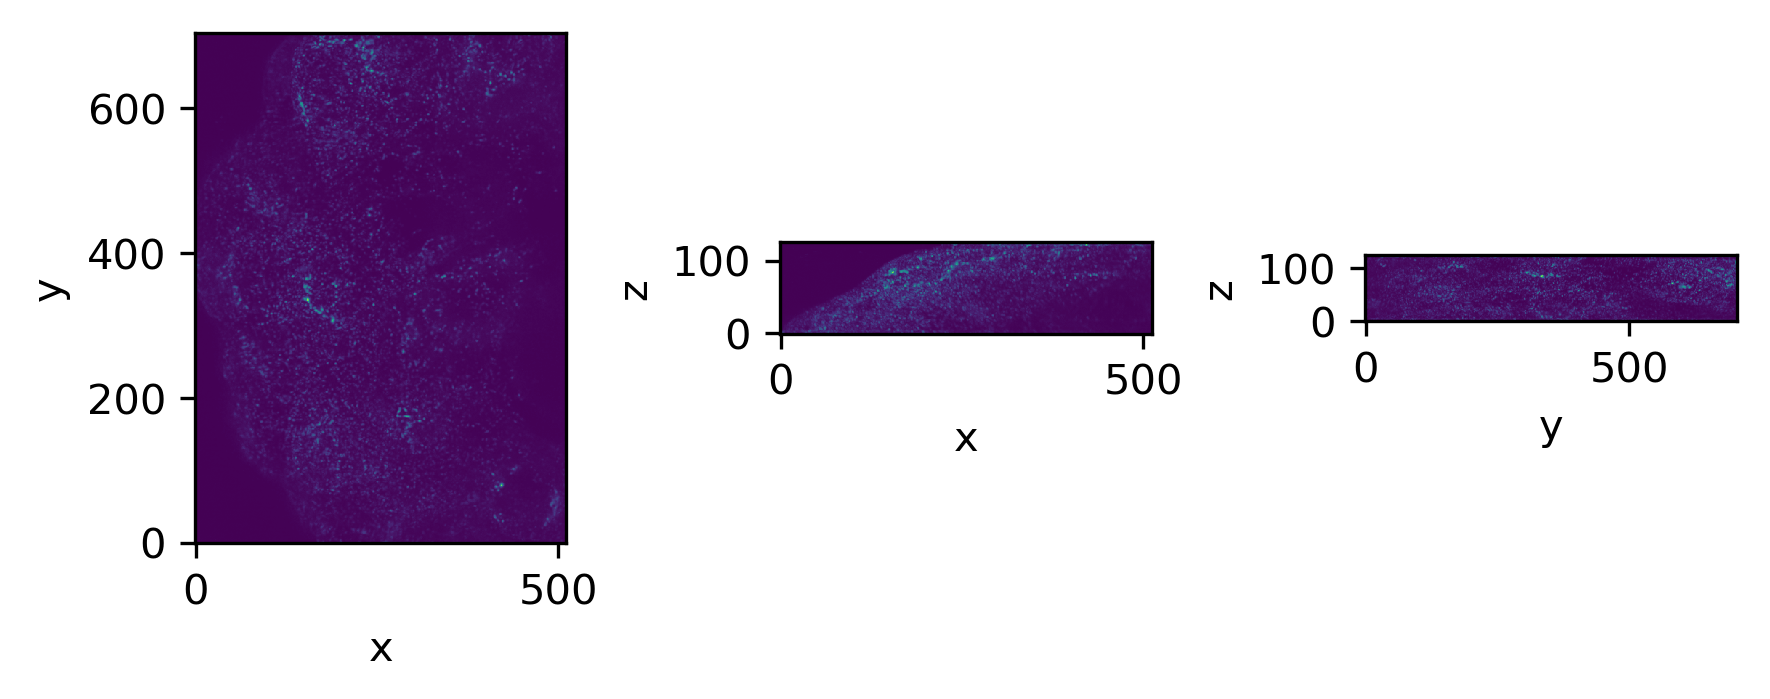

In [7]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

# determine the apical basolateral boundary

In [8]:
path = outputDataFolder+'/'+master_outputDataFolder+'/'
#path = "/Users/johannesschoeneberg/Desktop/PostDoc/drubin_lab/organoids_lattice_data/matlab_lsm_tools_aguet/data_560/"

allAverageZs = []
for i in range(1,71):
        
    filename = "puncta_"+str(i).zfill(2)+".csv"
    data = pd.read_csv(path+"/"+filename,header=0)
    data.columns = ["x","y","z","A"]
    
    # get all puncta
    
    idx = data.index[data['A'] > 0]

    # every axis is flippped in the matlab code (weird, I know)
    x = ((data['x']).loc[idx])
    y = ((data['y']).loc[idx])
    z = ((data['z']).loc[idx])
    
    yrange = [np.min(y),np.max(y)]
    xrange = [np.min(x),np.max(x)]
    #print(yrange)
    #print(xrange)
    yrange = [0,700]
    xrange = [0,500]
    nbins = 20
    xbinsize = (yrange[1]-yrange[0])/nbins
    ybinsize = (xrange[1]-xrange[0])/nbins
    
    xbins = np.arange(xrange[0], xrange[1]+1, xbinsize )
    ybins = np.arange(yrange[0], yrange[1]+1, ybinsize )
    zValues = []
    #print(bins)
    for i in range(1,len(xbins)):
        for j in range(1,len(ybins)):
            xleftThreshold = xbins[i-1]
            xrightThreshold = xbins[i]
            yleftThreshold = ybins[j-1]
            yrightThreshold = ybins[j]
            
            #filter out the z's that have the correct x range
            idx = data.index[(data['y'] > yleftThreshold)&(data['y'] < yrightThreshold)&(data['x'] > xleftThreshold)&(data['x'] < xrightThreshold)] 
            z = ((data['z']).loc[idx])
            zValues.append([xleftThreshold,xrightThreshold,yleftThreshold,yrightThreshold,z.values])
        
    #print(zValues)
    averageZs = []
    for zValuePerBin in zValues:
        averageZs.append(np.array([zValuePerBin[0]+(zValuePerBin[1]-zValuePerBin[0])/2,zValuePerBin[2]+(zValuePerBin[3]-zValuePerBin[2])/2,np.average(zValuePerBin[-1])]))
    
    averageZs = np.array(averageZs)


    allAverageZs.append(averageZs)
    



/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


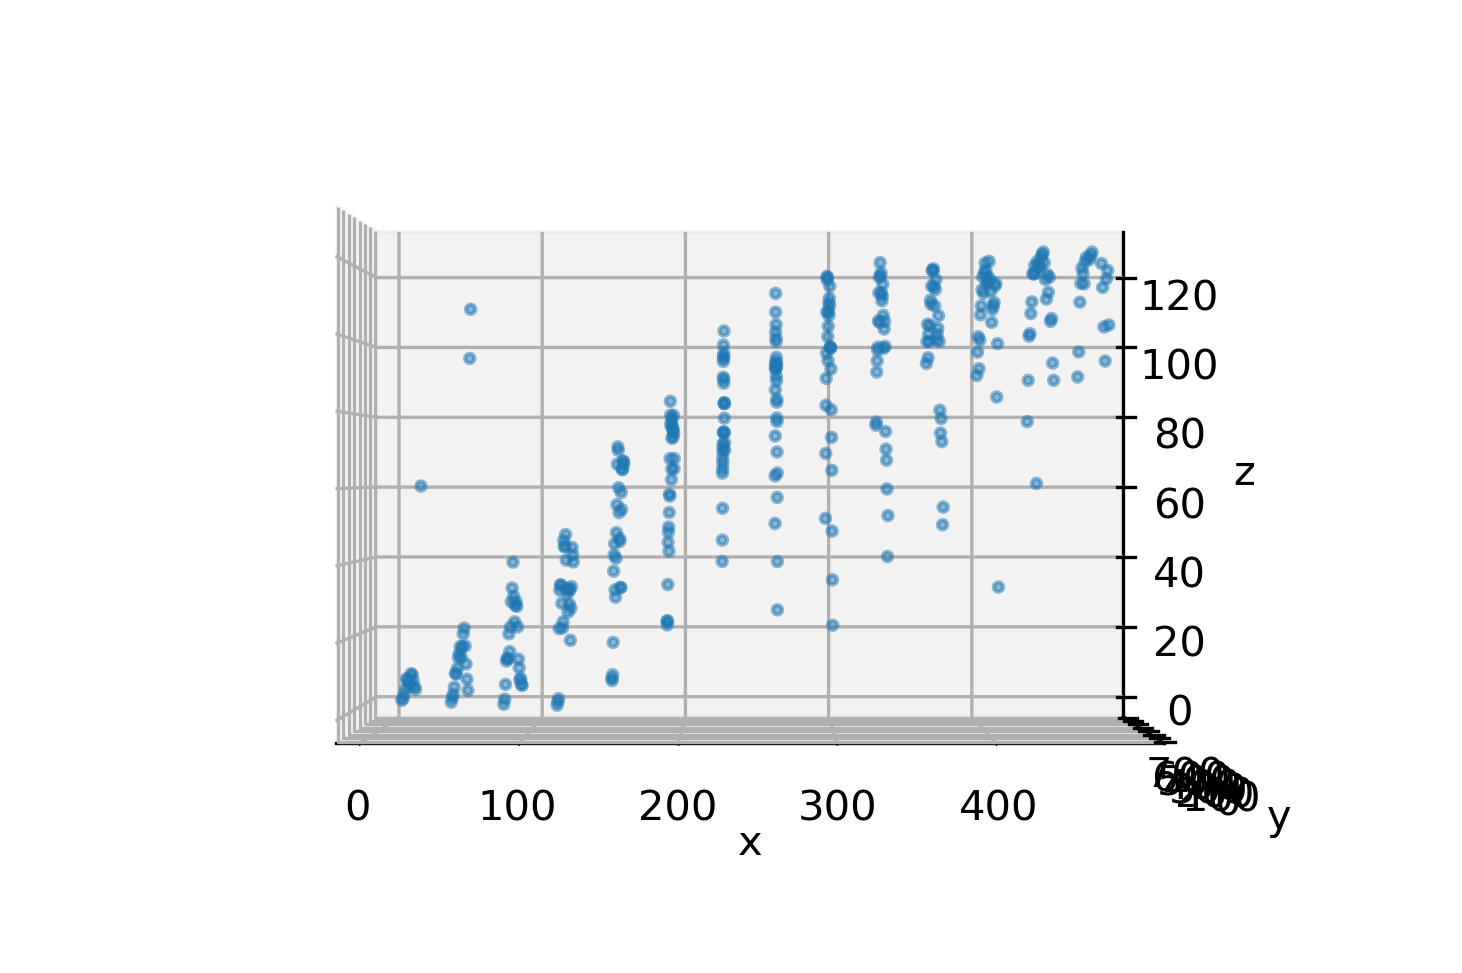

In [9]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
#X, Y, Z = axes3d.get_test_data(0.1)
#ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

#averageZs = allAverageZs[0]

averagedThresholdOverAllFrames = np.nanmean(allAverageZs[0:-1],axis=0)
averageZs = averagedThresholdOverAllFrames

plt.figure(dpi=300)

ax = plt.axes(projection='3d')
#    plt.title(title)
# Data for a three-dimensional line
x = averageZs[:,0]
y = averageZs[:,1]
z = averageZs[:,2]

#    ax.plot3D(x, y, z, 'gray')
ax.scatter3D(x, y, z, cmap='cool',alpha=0.5,s=5);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xangle = 0#90
yangle = -90
ax.view_init(xangle, yangle)
    
# rotate the axes and update
#for angle in range(0, 360):
#    
#    plt.draw()
#    plt.pause(.001)

# postprocess the thresholds so that they work !

In [10]:
#print(averagedThresholdOverAllFrames)
#print(averagedThresholdOverAllFrames)
# flip the z (mirror it)
averagedThresholdOverAllFrames[:,2]=abs(averagedThresholdOverAllFrames[:,2]-120)
#print()
#print(averagedThresholdOverAllFrames)

# read the tracking data for splitting

In [11]:
# read the raw csv data for further processing

path = outputDataFolder+'/'+trackingCsvFilenameProcessed
print(path)
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]





/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/output//trackedFeaturesProcessed.csv
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample3_CD_DMSO_10ulMG__Position4_O3_bleachCorr/output//trackedFeaturesProcessed.csv


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trackId,tracklength,time[s],frameId,lifetime,catIdx,m_x,m_y,m_z,m_A,m_c,m_pval_Ar,s_x,s_y,s_z,s_A,s_c,s_pval_Ar
0,1,70,0,1,398.23,4,5.544540e+01,4.349049e+02,1.077649e+02,7.433005e+03,2.289848e+03,0,5.544540e+01,4.349049e+02,1.077649e+02,4.395174e+02,5.677130e+03,1
1,1,70,5.689000e+00,2,398.23,4,5.614985e+01,4.350509e+02,1.088992e+02,7.333537e+03,2.717914e+03,0,5.799948e+01,4.337675e+02,1.088992e+02,6.644602e+03,6.219930e+03,3.946358e-123
2,1,70,1.137800e+01,3,398.23,4,5.687075e+01,4.370620e+02,1.080613e+02,7.793092e+03,2.640298e+03,0,5.687075e+01,4.370620e+02,1.080613e+02,-4.643558e+03,7.568141e+03,1
3,1,70,1.706700e+01,4,398.23,4,5.786911e+01,4.363405e+02,1.080086e+02,9.745618e+03,2.934876e+03,0,5.985629e+01,4.353998e+02,1.080086e+02,1.274150e+04,7.283068e+03,1.000000e+00
4,1,70,2.275600e+01,5,398.23,4,5.964148e+01,4.371584e+02,1.080364e+02,8.631816e+03,3.224502e+03,0,5.964148e+01,4.371584e+02,1.080364e+02,-2.172296e+03,7.863808e+03,1


# select subset

In [12]:
# select a subset of the tracks, e.g. for displaying only long tracks

#%----------------------------------------------------------------------------
#    % I. Assign category to each track
#    %----------------------------------------------------------------------------
#    % Categories:
#    % Ia)  Single tracks with valid gaps
#    % Ib)  Single tracks with invalid gaps
#    % Ic)  Single tracks cut at beginning or end
#    % Id)  Single tracks, persistent
#    % IIa) Compound tracks with valid gaps
#    % IIb) Compound tracks with invalid gaps
#    % IIc) Compound tracks cut at beginning or end
#    % IId) Compound tracks, persistent
#    
#    % The categories correspond to index 1-8, in the above order

allTrackIdsLrgrThanFour = (data[data['tracklength'] >= 4]).drop_duplicates(subset='trackId')['trackId'].values
allTrackIds = np.unique(data['trackId'].values)
cat_Ia_Tracks = np.unique(data[data['catIdx'] == 1]['trackId'])
cat_Ia_Tracks_long = np.unique(data[((data['catIdx'] == 1) & (data['tracklength'] > 4))]['trackId'])
cat_Ib_Tracks = np.unique(data[data['catIdx'] == 2]['trackId'])
cat_Ic_Tracks = np.unique(data[data['catIdx'] == 3]['trackId'])
cat_Ic_Tracks_long = np.unique(data[((data['catIdx'] == 3) & (data['tracklength'] > 4))]['trackId'])
cat_Id_Tracks = np.unique(data[data['catIdx'] == 4]['trackId'])
cat_IIa_Tracks = np.unique(data[data['catIdx'] == 5]['trackId'])
cat_IIb_Tracks = np.unique(data[data['catIdx'] == 6]['trackId'])
cat_IIc_Tracks = np.unique(data[data['catIdx'] == 7]['trackId'])
cat_IId_Tracks = np.unique(data[data['catIdx'] == 8]['trackId'])


print('len(allTrackIdsLrgrThanFour)/len(allTrackIds)')
print(str(len(allTrackIdsLrgrThanFour))+'/'+str(len(allTrackIds)))
print()
print(allTrackIdsLrgrThanFour)
print('/')
print(allTrackIds)
print()

len(allTrackIdsLrgrThanFour)/len(allTrackIds)
16002/31024

[    1     2     3 ..., 20561 20570 20948]
/
[    1     2     3 ..., 31022 31023 31024]



[31024, 16002, 22734, 7630, 13, 6645, 3509, 9, 831, 0, 786, 6]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Text(0.5,1,'N all: = 31024')

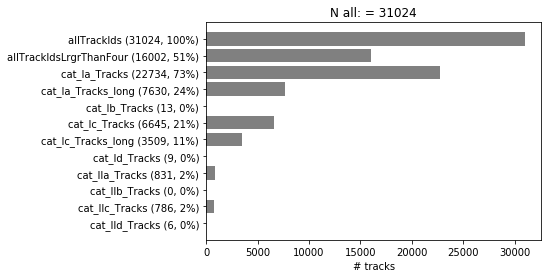

In [13]:
# plot a statistics fo the tracks in the different categories
categories = [allTrackIds,allTrackIdsLrgrThanFour,cat_Ia_Tracks,cat_Ia_Tracks_long,cat_Ib_Tracks,cat_Ic_Tracks,cat_Ic_Tracks_long,cat_Id_Tracks,cat_IIa_Tracks,cat_IIb_Tracks,cat_IIc_Tracks,cat_IId_Tracks]
categoryLabels = ["allTrackIds","allTrackIdsLrgrThanFour","cat_Ia_Tracks","cat_Ia_Tracks_long","cat_Ib_Tracks","cat_Ic_Tracks","cat_Ic_Tracks_long","cat_Id_Tracks","cat_IIa_Tracks","cat_IIb_Tracks","cat_IIc_Tracks","cat_IId_Tracks"]

categoryFrequency = []
for i in range(0,len(categories)):
    cat = categories[i]
    categoryFrequency.append(len(cat))
    percentage = int(len(cat)/len(allTrackIds)*100)
    categoryLabels[i]= categoryLabels[i]+' ('+str(len(cat))+', '+str(percentage)+'%)'
    
print(categoryFrequency)
fig, ax = plt.subplots()
y_pos = np.arange(len(categoryFrequency))

error = np.random.rand(len(categoryFrequency))
error = np.zeros(len(categoryFrequency))
print(error)

ax.barh(y_pos, categoryFrequency, xerr=error, align='center',
        color='grey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(categoryLabels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# tracks')
ax.set_title('N all: = '+str(len(allTrackIds)))

In [14]:
import re
def parseCutString(string):
    result = []
    #pattern match the indexing string
    chunks = re.findall("\\[[0-9]+,[0-9]+\\]",string)
    for chunk in chunks:
        indexes = re.findall("[0-9]+",chunk)
        if(len(indexes)==2):
            result.append([int(indexes[0]),int(indexes[1])])
        else:
            print("error: index \""+indexes+"\" cannot be parsed")

    return result

In [15]:
# align them all to the max

In [16]:

lifetimeCohorts = [[0, 6], [6,12],[12,18],[18,24],[24,30],[30,70]] #frames


In [17]:
print(xbinsize)

35.0


In [18]:
# data preprocessing

#maxIndexSlaveMustBeLargerThan = 0
interSpaceMargins=[15,5]#this is the value added[0]/subtracted[1] from the middle line for the inter classification

SlaveMaxAfterPercentCohortLength = 0.6
#trackIdsUsed = allTrackIds
trackIdsUsed = cat_Ia_Tracks_long

# take only those tracks that belong to the cohort:

#initialize the trackId array sorted by lifetime cohort
trackIdsAssignedToCohorts_api = []
trackIdsAssignedToCohorts_baso = []
trackIdsAssignedToCohorts_inter = []
for i in range(0,len(lifetimeCohorts)):
    trackIdsAssignedToCohorts_api.append(np.array([]))
    trackIdsAssignedToCohorts_baso.append(np.array([]))
    trackIdsAssignedToCohorts_inter.append(np.array([]))


baso = False

basoFirstXYZ=[]
basoLifetimes=[]
baso_mAmplitude=[] 
baso_sAmplitude=[]  

apiFirstXYZ=[]
apiLifetimes=[]
api_mAmplitude=[]
api_sAmplitude=[]

interFirstXYZ=[]
interLifetimes=[]
inter_mAmplitude=[]
inter_sAmplitude=[]

maxXIdxValue = max(averagedThresholdOverAllFrames[:,0])
maxYIdxValue = max(averagedThresholdOverAllFrames[:,1])

condition = -1 #0,1,2; api,inter,baso
for trackId in trackIdsUsed:
    track = data[data['trackId'] == trackId]
    tracklength = track['tracklength'].values[0]
    m_intensity = track['m_A'].values.astype(float)
    s_intensity = track['s_A'].values.astype(float)
    maxIdx = np.argmax(s_intensity)
    # only include those tracks that do not have the dynamin peak in the first three frames
    
    m_firstX = track['m_x'].values.astype(float)[0]
    m_firstY = track['m_y'].values.astype(float)[0]
    m_firstZ = track['m_z'].values.astype(float)[0]
    
    #determine into which x-y-bin for the zThreshold this track belongs
    xIdxValue = int(np.floor(m_firstX/xbinsize))*xbinsize +xbinsize/2     
    yIdxValue = int(np.floor(m_firstY/ybinsize))*ybinsize +ybinsize/2
    
    # if the puncta happens to be outside the grid, catch it again
    if(xIdxValue>maxXIdxValue):
        xIdxValue = maxXIdxValue 
    if(yIdxValue>maxYIdxValue):
        yIdxValue = maxYIdxValue
    
    #print("{}. {}".format(xIdxValue,yIdxValue))
    indexForThresholdArray = np.where((averagedThresholdOverAllFrames[:,0]==xIdxValue)&(averagedThresholdOverAllFrames[:,1]==yIdxValue))

    if(len(indexForThresholdArray[0])>0):
        zThreshold_apibaso =  averagedThresholdOverAllFrames[indexForThresholdArray][0][-1]
        zThreshold_api = zThreshold_apibaso-interSpaceMargins[1]
        zThreshold_baso = zThreshold_apibaso+interSpaceMargins[0]
        if (np.isnan(zThreshold_apibaso)):
            zThreshold_apibaso = 0
            
        if(m_firstZ < zThreshold_api):
            condition = 0
            apiFirstXYZ.append([m_firstX,m_firstY,m_firstZ])
            apiLifetimes.append(tracklength)
            api_mAmplitude.append(m_intensity)
            api_sAmplitude.append(s_intensity)
        else:
            if(m_firstZ > zThreshold_baso):
                condition = 1
                basoFirstXYZ.append([m_firstX,m_firstY,m_firstZ])
                basoLifetimes.append(tracklength)
                baso_mAmplitude.append(m_intensity)
                baso_sAmplitude.append(s_intensity)
            else:
                condition=2
                interFirstXYZ.append([m_firstX,m_firstY,m_firstZ])
                interLifetimes.append(tracklength)
                inter_mAmplitude.append(m_intensity)
                inter_sAmplitude.append(s_intensity)  
                    
            
        
        
        for i in range(0,len(lifetimeCohorts)):
            lifetimeLength = lifetimeCohorts[i][1]-lifetimeCohorts[i][0]
            #if(maxIdx >=maxIndexSlaveMustBeLargerThan):
            if(maxIdx >=SlaveMaxAfterPercentCohortLength*lifetimeLength):
                
                if((tracklength >lifetimeCohorts[i][0]) & (tracklength <=lifetimeCohorts[i][1])):
                    if(condition==0):
                        trackIdsAssignedToCohorts_api[i] = np.append(trackIdsAssignedToCohorts_api[i],trackId)
                    if(condition==1):
                        trackIdsAssignedToCohorts_baso[i] = np.append(trackIdsAssignedToCohorts_baso[i],trackId)
                    if(condition==2):
                        trackIdsAssignedToCohorts_inter[i] = np.append(trackIdsAssignedToCohorts_inter[i],trackId)
                
    else:
        #print(averagedThresholdOverAllFrames)
        print(indexForThresholdArray)
        print(m_firstX)
        print(m_firstY)
        print(m_firstZ)
        print(xIdxValue)
        print(yIdxValue)
        print('what?')
trackIdsAssignedToCohorts_api = np.array(trackIdsAssignedToCohorts_api)
trackIdsAssignedToCohorts_baso = np.array(trackIdsAssignedToCohorts_baso)
trackIdsAssignedToCohorts_inter = np.array(trackIdsAssignedToCohorts_inter)


print('api')
api_cohorts_n = []
#print(trackIdsAssignedToCohorts_api)
for cohortIdArray in trackIdsAssignedToCohorts_api:
    print(len(cohortIdArray))
    api_cohorts_n.append(len(cohortIdArray))
    
print('baso')
baso_cohorts_n = []
#print(trackIdsAssignedToCohorts_baso)
for cohortIdArray in trackIdsAssignedToCohorts_baso:
    print(len(cohortIdArray))
    baso_cohorts_n.append(len(cohortIdArray))
    
print('inter')
inter_cohorts_n = []
#print(trackIdsAssignedToCohorts_baso)
for cohortIdArray in trackIdsAssignedToCohorts_inter:
    print(len(cohortIdArray))
    inter_cohorts_n.append(len(cohortIdArray))

api
263
620
214
101
35
13
baso
254
635
284
142
47
20
inter
316
650
287
152
69
26


In [19]:
print("are all tracks classified?\n baso: {}, inter: {}, api: {}, both: {},  all: {}".format(np.sum(baso_cohorts_n),np.sum(inter_cohorts_n),np.sum(api_cohorts_n),np.sum(baso_cohorts_n)+np.sum(api_cohorts_n),len(trackIdsUsed)))

are all tracks classified?
 baso: 1382, inter: 1500, api: 1246, both: 2628,  all: 7630


In [20]:
colorCodeApiBasoInter = {'api':'grey', 'baso': 'black','inter':'blue'}
colorCodeApiBasoInter['api']

'grey'

Text(0,0.5,'z[px]')

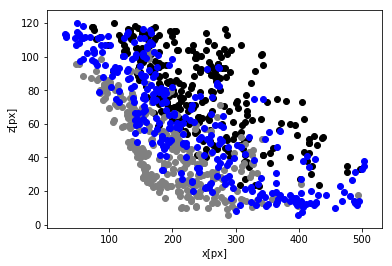

In [21]:
slicee=200
plt.scatter(np.array(basoFirstXYZ)[300:600,0],np.array(basoFirstXYZ)[300:600,2],c=colorCodeApiBasoInter['baso'])
plt.scatter(np.array(apiFirstXYZ)[300:600,0],np.array(apiFirstXYZ)[300:600,2],c=colorCodeApiBasoInter['api'])
plt.scatter(np.array(interFirstXYZ)[300:600,0],np.array(interFirstXYZ)[300:600,2],c=colorCodeApiBasoInter['inter'])
plt.xlabel('x[px]')
plt.ylabel('z[px]')

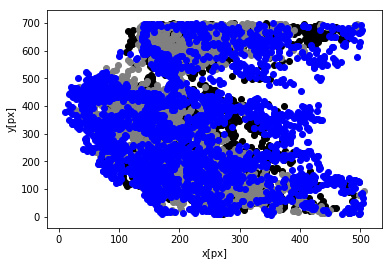

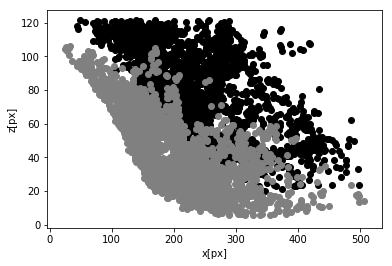

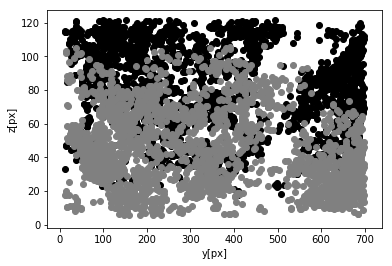

In [22]:
plt.scatter(np.array(basoFirstXYZ)[:,0],np.array(basoFirstXYZ)[:,1],c=colorCodeApiBasoInter['baso'])
plt.scatter(np.array(apiFirstXYZ)[:,0],np.array(apiFirstXYZ)[:,1],c=colorCodeApiBasoInter['api'])
plt.scatter(np.array(interFirstXYZ)[:,0],np.array(interFirstXYZ)[:,1],c=colorCodeApiBasoInter['inter'])
plt.xlabel('x[px]')
plt.ylabel('y[px]')
plt.show()
plt.scatter(np.array(basoFirstXYZ)[:,0],np.array(basoFirstXYZ)[:,2],c=colorCodeApiBasoInter['baso'])
plt.scatter(np.array(apiFirstXYZ)[:,0],np.array(apiFirstXYZ)[:,2],c=colorCodeApiBasoInter['api'])
#plt.scatter(np.array(interFirstXYZ)[:,0],np.array(interFirstXYZ)[:,2],c=colorCodeApiBasoInter['inter'])
plt.xlabel('x[px]')
plt.ylabel('z[px]')
plt.show()
plt.scatter(np.array(basoFirstXYZ)[:,1],np.array(basoFirstXYZ)[:,2],c=colorCodeApiBasoInter['baso'])
plt.scatter(np.array(apiFirstXYZ)[:,1],np.array(apiFirstXYZ)[:,2],c=colorCodeApiBasoInter['api'])
#plt.scatter(np.array(interFirstXYZ)[:,1],np.array(interFirstXYZ)[:,2],c=colorCodeApiBasoInter['inter'])
plt.xlabel('y[px]')
plt.ylabel('z[px]')
plt.show()



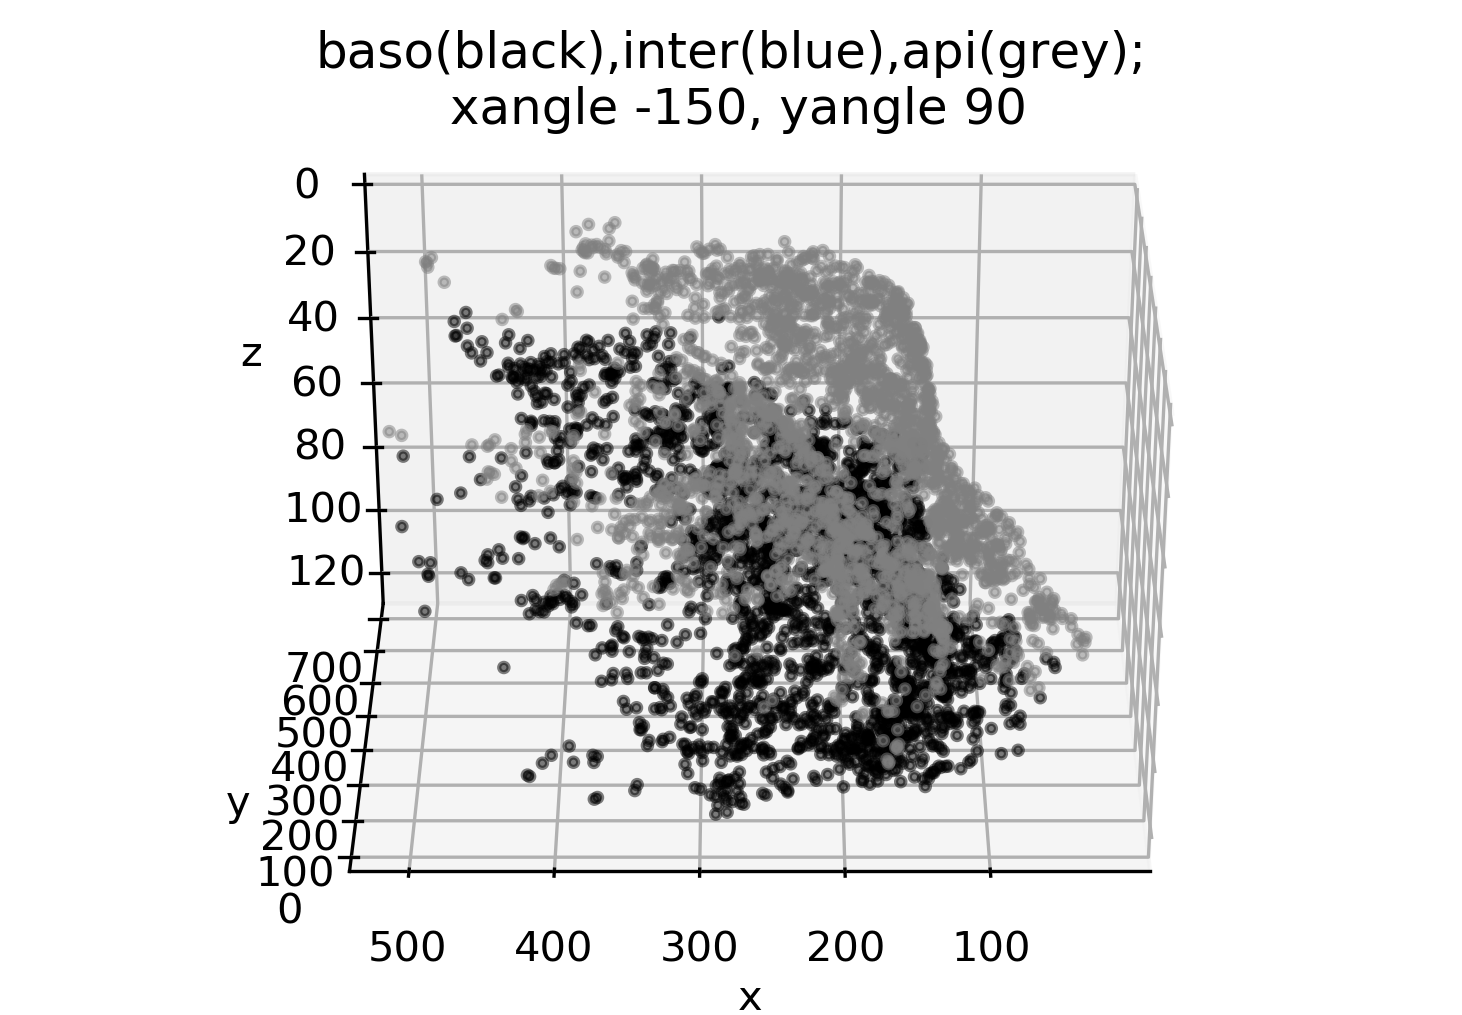

In [23]:
plt.figure(dpi=300)
ax = plt.axes(projection='3d')
ax.scatter3D(np.array(basoFirstXYZ)[:,0], np.array(basoFirstXYZ)[:,1], np.array(basoFirstXYZ)[:,2], color=colorCodeApiBasoInter['baso'],alpha=0.5,s=5);
#ax.scatter3D(np.array(interFirstXYZ)[:,0], np.array(interFirstXYZ)[:,1], np.array(interFirstXYZ)[:,2], color=colorCodeApiBasoInter['inter'],alpha=0.5,s=5);
ax.scatter3D(np.array(apiFirstXYZ)[:,0], np.array(apiFirstXYZ)[:,1], np.array(apiFirstXYZ)[:,2], color=colorCodeApiBasoInter['api'],alpha=0.5,s=5);

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xangle = -150#90
yangle = 90
ax.view_init(xangle, yangle)
plt.title('baso('+colorCodeApiBasoInter['baso']+'),inter('+colorCodeApiBasoInter['inter']+'),api('+colorCodeApiBasoInter['api']+');\n xangle {}, yangle {}'.format(xangle,yangle))
plt.show()